In [1]:
%matplotlib inline
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from tqdm import tqdm_notebook as tqdm
from keras.models import Model
from keras.layers import Input, Reshape , concatenate
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
from sklearn.metrics import  confusion_matrix

np.random.seed(1337)
num_classes = 10

Using TensorFlow backend.


In [2]:
data = pd.read_csv('creditcard.csv')
data_x = data[data.Class == 0]
data_x.shape
data_x = data_x.drop(['Time','Class'], axis = 1)
from sklearn.preprocessing import StandardScaler
data['normalizedAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data = data.drop(['Amount','Time'],axis=1)
# data.head()
#data.head()

In [3]:
## Model Training for Classification
X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=0)

In [4]:
"""
VISUALISATION

"""

'\nVISUALISATION\n\n'

In [29]:
X.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'normalizedAmount'],
      dtype='object')

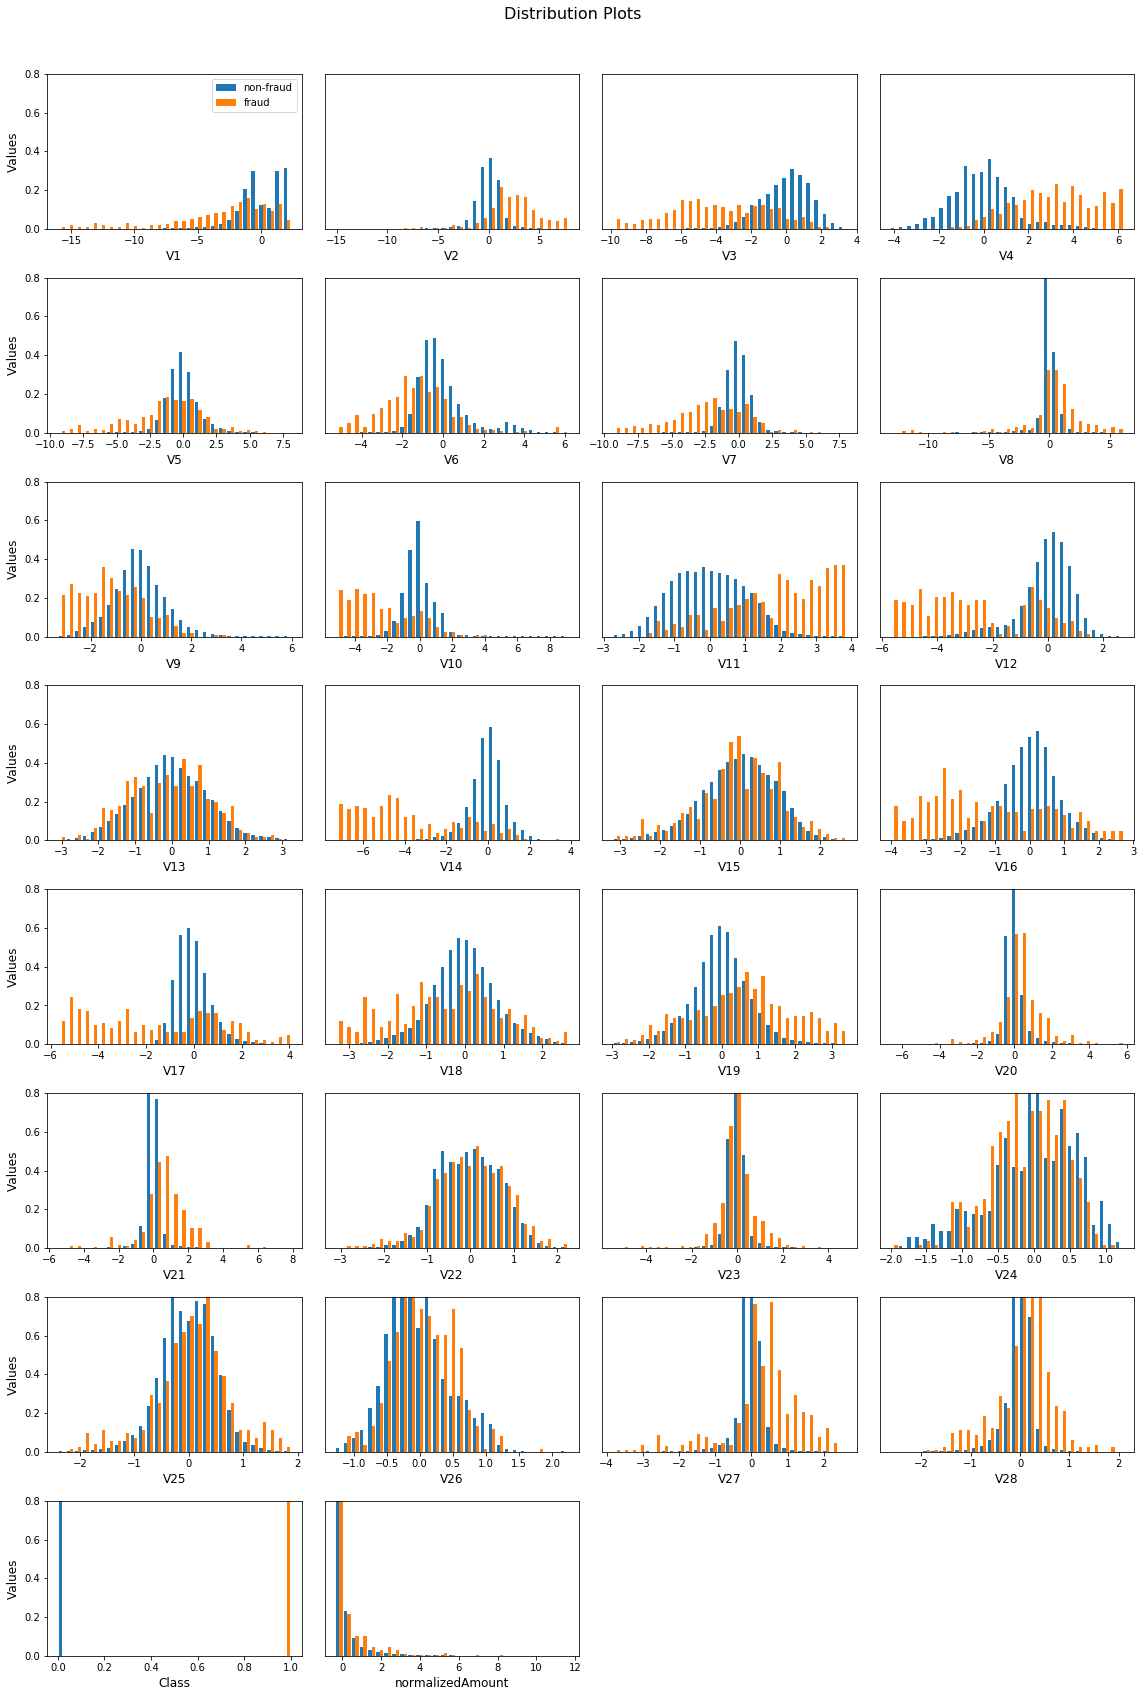

In [6]:
# Plot the data by each feature

axarr = [[]]*len(data.columns)
columns = 4
rows = int( np.ceil( len(data.columns) / columns ) )
f, fig = plt.subplots( figsize=(columns*4, rows*3) )

f.suptitle('Distribution Plots', size=16)

for i, col in enumerate(data.columns[:]):
    axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
    axarr[i].hist( [ data.loc[ data.Class == 0, col ], data.loc[ data.Class == 1, col ] ], label=['non-fraud','fraud'], 
                          bins=np.linspace( np.percentile(data[col],0.1), np.percentile(data[col],99.9), 30 ),
                          normed=True )
    axarr[i].set_xlabel(col, size=12)
    axarr[i].set_ylim([0,0.8])
    axarr[i].tick_params(axis='both', labelsize=10)
    if i == 0: 
        legend = axarr[i].legend()
        legend.get_frame().set_facecolor('white')
    if i%4 != 0 : 
        axarr[i].tick_params(axis='y', left='off', labelleft='off')
    else:
        axarr[i].set_ylabel('Values',size=12)

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
# plt.savefig('plots/Engineered_Data_Distributions.png')


In [7]:
# Feature importance
from sklearn import decomposition
from sklearn.ensemble import ExtraTreesClassifier
np.random.seed(77)

df = pd.read_csv('creditcard.csv')
df.Amount = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
X_x = df.iloc[:, df.columns != 'Class']
y_y = df.iloc[:, df.columns == 'Class']
X_names = df.columns.values[:-1]

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=100, random_state=0)

forest.fit(X_x, y_y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]



Feature ranking:
1. feature V14 (0.146463)
2. feature V17 (0.128167)
3. feature V12 (0.098234)
4. feature V11 (0.071872)
5. feature V10 (0.071293)
6. feature V16 (0.062060)
7. feature V18 (0.039392)
8. feature V4 (0.038146)
9. feature V9 (0.033378)
10. feature V3 (0.030794)
11. feature V7 (0.026774)
12. feature Time (0.016980)
13. feature V21 (0.016969)
14. feature V19 (0.016041)
15. feature V26 (0.014639)
16. feature V2 (0.014524)
17. feature V5 (0.014298)
18. feature V8 (0.013980)
19. feature V1 (0.013845)
20. feature V22 (0.013195)
21. feature V6 (0.013114)
22. feature V20 (0.013034)
23. feature V24 (0.012639)
24. feature V13 (0.012569)
25. feature Amount (0.012227)
26. feature V27 (0.012112)
27. feature V15 (0.011850)
28. feature V28 (0.011394)
29. feature V23 (0.010034)
30. feature V25 (0.009981)


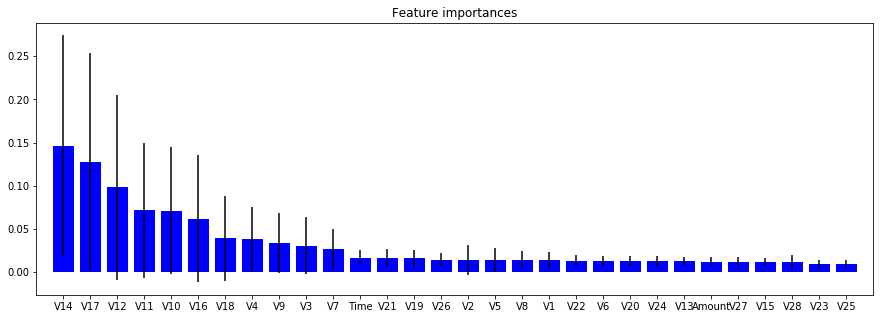

In [8]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X_x.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_names[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize= (15, 5 ))
plt.title("Feature importances")
plt.bar(range(X_x.shape[1]), importances[indices],
       color="blue", yerr=std[indices], align="center")
plt.xticks(range(X_x.shape[1]), X_names[indices])
plt.xlim([-1, X_x.shape[1]])
plt.show()

In [9]:
print(X_names[indices])

['V14' 'V17' 'V12' 'V11' 'V10' 'V16' 'V18' 'V4' 'V9' 'V3' 'V7' 'Time'
 'V21' 'V19' 'V26' 'V2' 'V5' 'V8' 'V1' 'V22' 'V6' 'V20' 'V24' 'V13'
 'Amount' 'V27' 'V15' 'V28' 'V23' 'V25']


In [10]:
# top 4 features

top_4 = X_names[indices][:6]
print(top_4)

X_top_4 = df[top_4]
print(X_top_4)

top4df = pd.concat([df['Time'], X_top_4, y_y], axis= 1)

['V14' 'V17' 'V12' 'V11' 'V10' 'V16']
             V14       V17       V12       V11       V10       V16
0      -0.311169  0.207971 -0.617801 -0.551600  0.090794 -0.470401
1      -0.143772 -0.114805  1.065235  1.612727 -0.166974  0.463917
2      -0.165946  1.109969  0.066084  0.624501  0.207643 -2.890083
3      -0.287924 -0.684093  0.178228 -0.226487 -0.054952 -1.059647
4      -1.119670 -0.237033  0.538196 -0.822843  0.753074 -0.451449
...          ...       ...       ...       ...       ...       ...
284802  4.626942  1.991691  2.711941 -1.593105  4.356170  1.107641
284803 -0.675143 -0.025693  0.915802 -0.150189 -0.975926 -0.711757
284804 -0.510602  0.313502  0.063119  0.411614 -0.484782  0.140716
284805  0.449624  0.509928 -0.962886 -1.933849 -0.399126 -0.608577
284806 -0.084316 -0.660377 -0.031513 -1.040458 -0.915427 -0.302620

[284807 rows x 6 columns]


In [11]:
top4df.head()

,Time,V14,V17,V12,V11,V10,V16,Class
0,0.0,-0.311169,0.207971,-0.617801,-0.551600,0.090794,-0.470401,0
1,0.0,-0.143772,-0.114805,1.065235,1.612727,-0.166974,0.463917,0
2,1.0,-0.165946,1.109969,0.066084,0.624501,0.207643,-2.890083,0
3,1.0,-0.287924,-0.684093,0.178228,-0.226487,-0.054952,-1.059647,0
4,2.0,-1.119670,-0.237033,0.538196,-0.822843,0.753074,-0.451449,0


In [12]:
for i in range(6):
    col1= top4df.columns.values[i+1]
    print(col1)

V14
V17
V12
V11
V10
V16


In [13]:
'''

THIS IS WHERE THE PREDICTION MODEL ENDS

NEXT: NEURAL NETWORK MODEL

'''

'\n\nTHIS IS WHERE THE PREDICTION MODEL ENDS\n\nNEXT: NEURAL NETWORK MODEL\n\n'

In [14]:
data = top4df.groupby('Class')
print(data['V12'])

In [4]:
# Initialising the ANN
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units =20 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 29))
# Adding the second hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
# Adding the third hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# Fitting the ANN to the Training set
# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
199364/199364 [==============================] - 12s 62us/step - loss: 0.0146 - accuracy: 0.9984
Epoch 2/100
199364/199364 [==============================] - 11s 55us/step - loss: 0.0032 - accuracy: 0.9994
Epoch 3/100
199364/199364 [==============================] - 11s 55us/step - loss: 0.0029 - accuracy: 0.9994
Epoch 4/100
199364/199364 [==============================] - 11s 55us/step - loss: 0.0028 - accuracy: 0.9994
Epoch 5/100
199364/199364 [==============================] - 11s 57us/step - loss: 0.0026 - accuracy: 0.9994
Epoch 6/100
199364/199364 [==============================] - 11s 55us/step - loss: 0.0026 - accuracy: 0.9994
Epoch 7/100
199364/199364 [==============================] - 11s 55us/step - loss: 0.0026 - accuracy: 0.9994
Epoch 8/100
199364/199364 [==============================] - 11s 55us/step - loss: 0.0024 - accuracy: 0.9994
Epoch 9/100
199364/199364 [==============================] - 11s 54us/step - loss: 0.0024 - accuracy: 0.9994
Epoch 10/100
199364

In [5]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)
score = classifier.evaluate(X_test, y_test)
score

85443/85443 [==============================] - 2s 19us/step


[0.005786434631601379, 0.9994031190872192]

In [6]:
confusion_matrix(y_test, y_pred)

array([[85278,    18],
       [   33,   114]])

In [7]:
# GENERATOR
def get_generative(G_in, dense_dim=20, out_dim=29, lr=1e-3):
    x = Dense(dense_dim)(G_in)
    x = Activation('tanh')(x)
    G_out = Dense(out_dim, activation='tanh')(x)
    G = Model(G_in, G_out)
    opt = SGD(lr=lr)
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G, G_out

G_in = Input(shape=(10,))
G, G_out = get_generative(G_in)
G.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                220       
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 29)                609       
Total params: 829
Trainable params: 829
Non-trainable params: 0
_________________________________________________________________


In [8]:
 def get_discriminative(D_in, lr=1e-3, drate=.25, n_channels=20, conv_sz=3, leak=.2):
    x = Reshape((-1, 1))(D_in)
    x = Conv1D(n_channels, conv_sz, activation='relu')(x)
    x = Dropout(drate)(x)
    x = Flatten()(x)
    x = Dense(n_channels)(D_in)
    D_out = Dense(2, activation='sigmoid')(x)
    D = Model(D_in, D_out)
    dopt = Adam(lr=lr)
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    return D, D_out

D_in = Input(shape=[29])
D, D_out = get_discriminative(D_in)
D.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                600       
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 42        
Total params: 642
Trainable params: 642
Non-trainable params: 0
_________________________________________________________________


In [9]:
def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable
        
def make_gan(GAN_in, G, D):
    set_trainability(D, False)
    x = G(GAN_in)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out

GAN_in = Input([10])
GAN, GAN_out = make_gan(GAN_in, G, D)
GAN.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10)                0         
_________________________________________________________________
model_1 (Model)              (None, 29)                829       
_________________________________________________________________
model_2 (Model)              (None, 2)                 642       
Total params: 1,471
Trainable params: 829
Non-trainable params: 642
_________________________________________________________________


In [10]:
X_train.shape

(199364, 29)

In [11]:
def sample_data_and_gen(G, n_samples=10000, noise_dim=10):
    random_indices = np.random.choice(199363, size=n_samples, replace=False)
    xx_train = np.array(X_train)
    XT = xx_train[random_indices]
    XN_noise = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    #print(XN_noise)
    XN = G.predict(XN_noise)
    X = np.concatenate((XT, XN))
    y = np.zeros((2*n_samples, 2))
    y[:n_samples, 1] = 1
    y[n_samples:, 0] = 1
    return X, y

def pretrain(G, D, noise_dim=10, n_samples=10000, batch_size=32):
    X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
    #print(X,y)
    set_trainability(D, True)
    D.fit(X, y, epochs=200, batch_size=32)

pretrain(G, D)

Epoch 1/200
20000/20000 [==============================] - 1s 66us/step - loss: 0.3843
Epoch 2/200
20000/20000 [==============================] - 1s 42us/step - loss: 0.2361
Epoch 3/200
20000/20000 [==============================] - 1s 44us/step - loss: 0.2084
Epoch 4/200
20000/20000 [==============================] - 1s 46us/step - loss: 0.1988
Epoch 5/200
20000/20000 [==============================] - 1s 45us/step - loss: 0.1946
Epoch 6/200
20000/20000 [==============================] - 1s 43us/step - loss: 0.1910
Epoch 7/200
20000/20000 [==============================] - 1s 41us/step - loss: 0.1903
Epoch 8/200
20000/20000 [==============================] - 1s 41us/step - loss: 0.1891
Epoch 9/200
20000/20000 [==============================] - 1s 43us/step - loss: 0.1877
Epoch 10/200
20000/20000 [==============================] - 1s 43us/step - loss: 0.1868
Epoch 11/200
20000/20000 [==============================] - 1s 41us/step - loss: 0.1856
Epoch 12/200
20000/20000 [===============

In [12]:
def sample_noise(G, noise_dim=10, n_samples=1000):
    X = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    y = np.zeros((n_samples, 2))
    y[:, 1] = 1
    return X, y


def train(GAN, G, D, epochs=400, n_samples=1000, noise_dim=10, batch_size=32, verbose=False, v_freq=50):
    d_loss = []
    g_loss = []
    e_range = range(epochs)
    if verbose:
        e_range = tqdm(e_range)
    for epoch in e_range:
        X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
        print(X.shape)
        set_trainability(D, True)
        d_loss.append(D.train_on_batch(X, y))
        
        X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim)
        
        set_trainability(D, False)
        g_loss.append(GAN.train_on_batch(X, y))
        if verbose and (epoch + 1) % v_freq == 0:
            print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
    return d_loss, g_loss

In [13]:

d_loss, g_loss = train(GAN, G, D, verbose=True)

(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
Epoch #50: Generative Loss: 0.17365358769893646, Discriminative Loss: 1.8616024255752563
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29)
(2000, 29

Text(0, 0.5, 'loss')

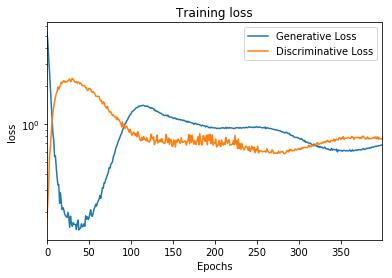

In [166]:
ax = pd.DataFrame(
    {
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("loss")

In [103]:
N_VIEWED_SAMPLES = 2
X_gen , y_gen = sample_data_and_gen(G, n_samples=100000)


In [104]:
X_gen = X_gen[100000:, :]
print(X_gen)

[[ 0.13215257  0.17152792 -0.24359614 ...  0.38391516 -0.32159942
  -0.16780668]
 [ 0.2674877  -0.14334847 -0.06786395 ...  0.25885445 -0.28123471
   0.01986951]
 [ 0.39933652 -0.42396095 -0.17919333 ...  0.20950085 -0.2245501
   0.0157368 ]
 ...
 [ 0.28603631 -0.31234726 -0.1371114  ...  0.2200108  -0.26352829
  -0.2437411 ]
 [ 0.16761614 -0.27463791 -0.18787913 ...  0.04339404 -0.18557398
  -0.00657822]
 [ 0.07449874 -0.03598993 -0.1677597  ...  0.32391769 -0.13573492
  -0.05298359]]


In [105]:
yg = np.zeros((len(X_gen), 1))
yg[:] = 0
print(yg)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [106]:
yg.shape

(100000, 1)

In [107]:
y_pred = classifier.predict(X_gen)
print("Number of data samples wrongly classified: ", len(y_pred[y_pred[:] >= 0.5]))

Number of data samples wrongly classified:  80818


In [108]:
print(len(y_pred[y_pred[:] >= 0.5]))

80818


In [109]:
y_pred = (y_pred > 0.5)
score = classifier.evaluate(X_gen, yg)
print(score)

100000/100000 [==============================] - 2s 18us/step
[2.4255575479888916, 0.19181999564170837]


In [110]:
confusion_matrix(y_pred, yg)

array([[19182,     0],
       [80818,     0]])

In [111]:
gen_data = np.hstack((X_gen, yg))

In [112]:
col_names = X.columns.values
col_names = np.append(col_names, ["Class"])
print(col_names)

['V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7' 'V8' 'V9' 'V10' 'V11' 'V12' 'V13'
 'V14' 'V15' 'V16' 'V17' 'V18' 'V19' 'V20' 'V21' 'V22' 'V23' 'V24' 'V25'
 'V26' 'V27' 'V28' 'normalizedAmount' 'Class']


In [113]:
df_gen = pd.DataFrame(data=gen_data, columns=col_names)
df_gen.Class = 0
df_gen.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,normalizedAmount,Class
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0
mean,0.139802,-0.135420,-0.175759,0.031554,-0.127138,0.045208,-0.089321,-0.021306,-0.023844,0.015863,...,0.096130,0.002843,-0.149482,0.118083,0.004537,-0.006698,0.158121,-0.226229,-0.013145,0.0
std,0.134144,0.195333,0.104955,0.236097,0.167767,0.150776,0.224293,0.072969,0.191606,0.147260,...,0.197072,0.136587,0.161313,0.129771,0.180236,0.145282,0.130006,0.074466,0.150168,0.0
min,-0.332965,-0.671234,-0.520569,-0.665928,-0.632385,-0.430349,-0.748335,-0.274376,-0.615786,-0.482905,...,-0.515940,-0.476716,-0.578432,-0.356562,-0.545891,-0.497247,-0.303200,-0.439643,-0.529334,0.0
25%,0.046182,-0.278210,-0.250663,-0.139845,-0.249879,-0.060444,-0.254422,-0.071887,-0.161809,-0.092184,...,-0.046333,-0.092739,-0.271932,0.027827,-0.125289,-0.108909,0.066492,-0.281262,-0.118730,0.0
50%,0.143190,-0.142235,-0.179133,0.033332,-0.129516,0.044046,-0.094210,-0.021142,-0.024597,0.015752,...,0.100680,0.004403,-0.153951,0.120573,0.005573,-0.006873,0.161013,-0.228134,-0.012871,0.0
75%,0.236189,0.001591,-0.104539,0.204397,-0.006997,0.150243,0.072607,0.029293,0.113595,0.124051,...,0.241259,0.099654,-0.032179,0.210388,0.135532,0.094400,0.252296,-0.172124,0.092222,0.0
max,0.555591,0.530729,0.219825,0.704950,0.419815,0.545773,0.613145,0.250274,0.589093,0.505754,...,0.652667,0.462474,0.364671,0.555655,0.534789,0.493891,0.539937,0.025331,0.535671,0.0


In [76]:
def df_column_switch(df, column1, column2):
    i = list(df.columns)
    a, b = i.index(column1), i.index(column2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df

data = df_column_switch(data, 'Class', 'normalizedAmount')


In [139]:
fraud  = data[data.Class == 1]
df_gen.Class = 2
gen_data = pd.concat([data,df_gen ])

In [140]:
gen_data.shape

(384807, 30)

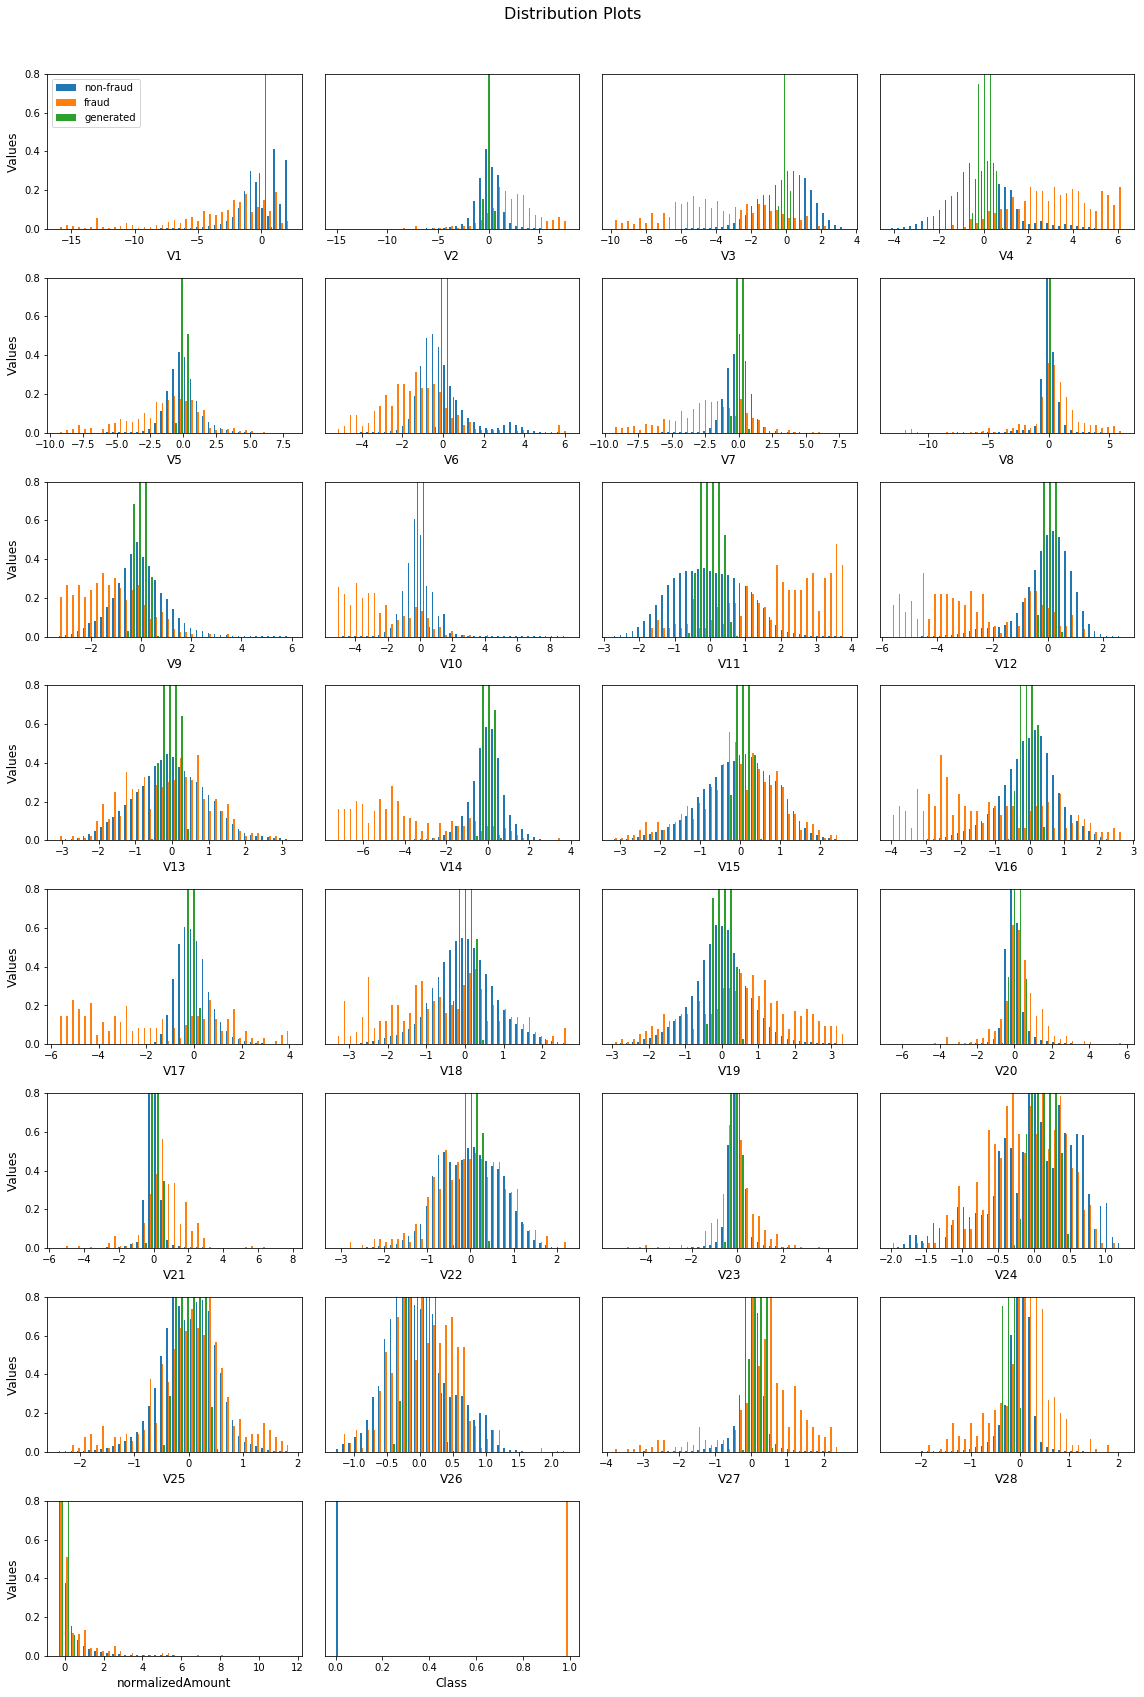

In [145]:
axarr = [[]]*len(df_gen.columns)
columns = 4
rows = int( np.ceil( len(df_gen.columns) / columns ) )
f, fig = plt.subplots( figsize=(columns*4, rows*3) )

f.suptitle('Distribution Plots', size=16)

for i, col in enumerate(data.columns[:]):
    axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
    axarr[i].hist( [ gen_data.loc[ gen_data.Class == 0, col ], gen_data.loc[ gen_data.Class == 1, col ], gen_data.loc[ gen_data.Class == 2, col ] ], label=['non-fraud','fraud', 'generated'], 
                          bins=np.linspace( np.percentile(data[col],0.1), np.percentile(data[col],99.9), 40 ),
                          normed=True )
    axarr[i].set_xlabel(col, size=12)
    axarr[i].set_ylim([0,0.8])
    axarr[i].tick_params(axis='both', labelsize=10)
    if i == 0: 
        legend = axarr[i].legend()
        legend.get_frame().set_facecolor('white')
    if i%4 != 0 : 
        axarr[i].tick_params(axis='y', left='off', labelleft='off')
    else:
        axarr[i].set_ylabel('Values',size=12)

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
# plt.savefig('plots/Engineered_Data_Distributions.png')


In [157]:
fraud  = data[data.Class == 1]
nonfraud  = data[data.Class == 0]

In [158]:
df_gen.Class = 0

In [159]:

train_gen = pd.concat([nonfraud.sample(10000), fraud.sample(150), df_gen])

In [160]:
X_train_new = train_gen.iloc[:, train_gen.columns != 'Class']
y_train_new = train_gen.iloc[:, train_gen.columns == 'Class']

In [161]:
print(y_train_new[y_train_new.Class == 2])

Empty DataFrame
Columns: [Class]
Index: []


In [162]:
# Initialising the ANN
classifier1 = Sequential()
classifier1.add(Dense(units =20 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 29))
classifier1.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
classifier1.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
classifier1.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

classifier1.fit(X_train_new, y_train_new, batch_size = 32, epochs = 100)

Epoch 1/100
110150/110150 [==============================] - 8s 71us/step - loss: 0.0252 - accuracy: 0.9986
Epoch 2/100
110150/110150 [==============================] - 6s 53us/step - loss: 0.0025 - accuracy: 0.9988
Epoch 3/100
110150/110150 [==============================] - 6s 53us/step - loss: 0.0019 - accuracy: 0.9997
Epoch 4/100
110150/110150 [==============================] - 6s 55us/step - loss: 0.0015 - accuracy: 0.9998
Epoch 5/100
110150/110150 [==============================] - 6s 54us/step - loss: 0.0014 - accuracy: 0.9997
Epoch 6/100
110150/110150 [==============================] - 6s 54us/step - loss: 0.0012 - accuracy: 0.9998
Epoch 7/100
110150/110150 [==============================] - 6s 52us/step - loss: 0.0011 - accuracy: 0.9998
Epoch 8/100
110150/110150 [==============================] - 6s 52us/step - loss: 0.0010 - accuracy: 0.9998
Epoch 9/100
110150/110150 [==============================] - 6s 52us/step - loss: 8.9603e-04 - accuracy: 0.9998
Epoch 10/100
110150/1101

In [163]:
# Predicting and Evaluating of the validation set
y_pred = classifier1.predict(X_test)
y_pred = (y_pred > 0.5)
score = classifier1.evaluate(X_test, y_test)
score
confusion_matrix(y_test, y_pred)

85443/85443 [==============================] - 2s 19us/step


[0.015132003210294525, 0.9975070953369141]

array([[85104,   192],
       [   21,   126]])

In [ ]:
# Feature importance for GAN model

np.random.seed(77)

df = pd.read_csv('creditcard.csv')
df.Amount = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))

X_names = train_gen.columns.values[:-1]

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=100, random_state=0)

forest.fit(X_train_new, y_train_new)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [ ]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X_x.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_names[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize= (15, 5 ))
plt.title("Feature importances")
plt.bar(range(X_x.shape[1]), importances[indices],
       color="blue", yerr=std[indices], align="center")
plt.xticks(range(X_x.shape[1]), X_names[indices])
plt.xlim([-1, X_x.shape[1]])
plt.show()